# Модели классификации
За позитивные объекты взяты те у которых Target>3, то есть цена за год утраивается.

Датасет содержит 50(2,4%) позитивных и 1996(97,6%) негативных объектов.

Понижение размерности не позволяет выделить позитивные объекты в отдельный кластер.

|Модель        |AUC                |
|--------------|-------------------|
|RandomForest  | 0.665             |
|XGBoost       | 0.715             |
|Newral Network| 0.662             |


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white')

In [2]:
ipo_file_path = 'Test.csv'
ipo_data = pd.read_csv(ipo_file_path, index_col=0)

The dataset contains 50(2.4%) positive samples and 1996 (97.6%) negative samples


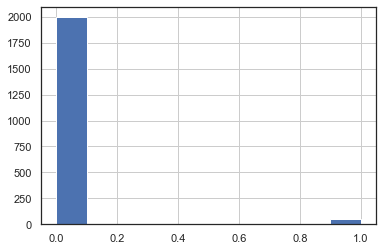

In [3]:
# use all columns except the target as features
X = ipo_data.drop('Target', axis=1)

y = (ipo_data['Target']>3).astype(int)
y.hist()
print(f'The dataset contains {y[y==1].count()}({y[y==1].count()/y.count():.1%}) positive samples and \
{y[y==0].count()} ({y[y==0].count()/y.count():.1%}) negative samples')

# Методы снижения размерности

In [14]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


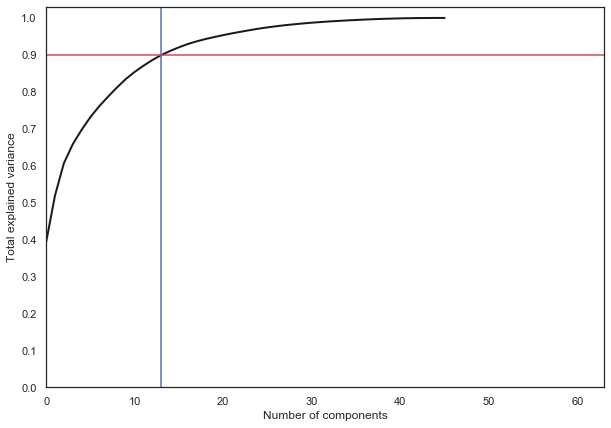

In [13]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(13, c='b')
plt.axhline(0.9, c='r')
plt.show();

#### sklearn PCA method

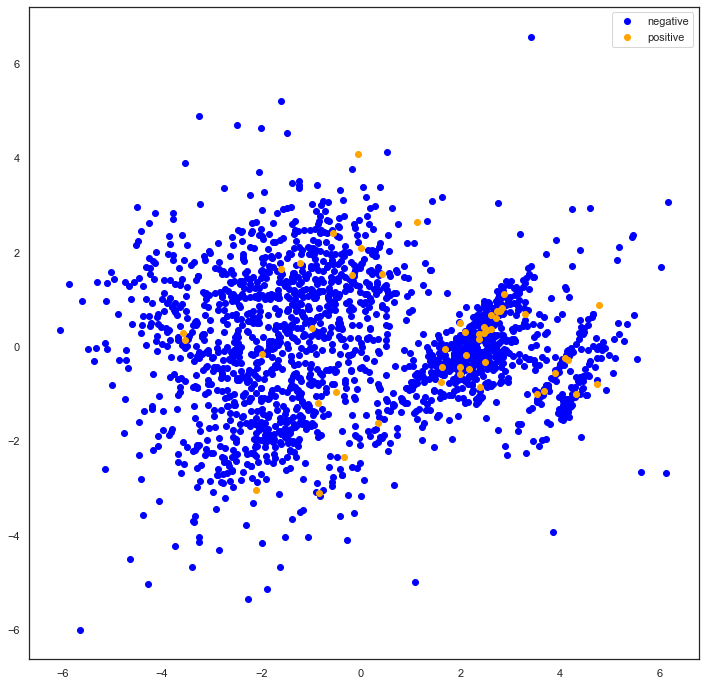

In [87]:
pca = decomposition.PCA(n_components=46)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
fig = plt.figure(n, figsize=(12, 12))
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'o', color='blue', label='negative')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'o', color='orange', label='positive')
plt.legend(loc=0);


#### sklearn  t-SNE method

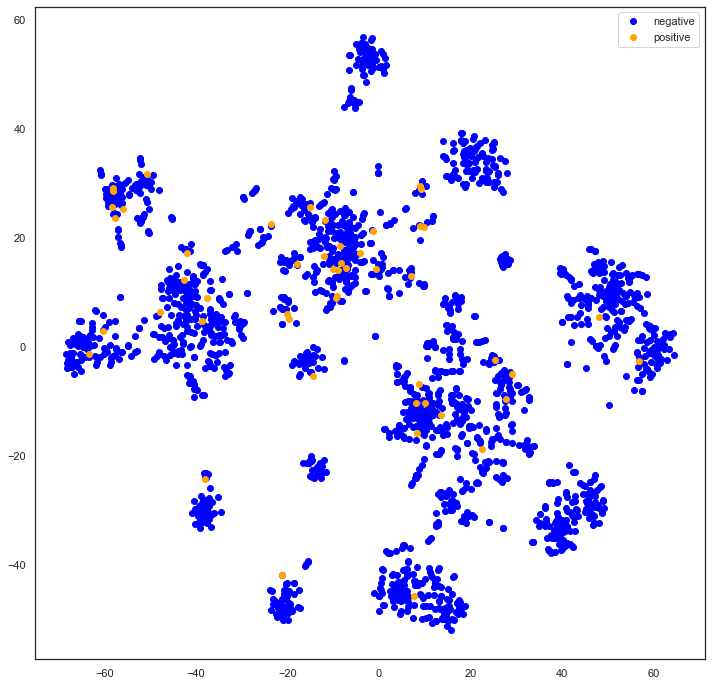

In [85]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure(n, figsize=(12, 12))
plt.plot(X_tsne[y == 0, 0], X_tsne[y == 0, 1], 'o', color='blue', label='negative')
plt.plot(X_tsne[y == 1, 0], X_tsne[y == 1, 1], 'o', color='orange', label='positive')
plt.legend(loc=0);


## RandomForestClassifier  (Cross validation)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [24]:
metric = 'roc_auc'
for est in [1,5,10,20,40,50,75,100,150,200,400,500,700,1000]:
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = cross_val_score(RandomForestClassifier(n_estimators=est, random_state=42),
                             X, y,
                             cv=5,
                             scoring=metric)
    print(f'estimators={est}\t\t{metric}:{scores.mean():.3f}')


estimators=1		roc_auc:0.499
estimators=5		roc_auc:0.537
estimators=10		roc_auc:0.561
estimators=20		roc_auc:0.588
estimators=40		roc_auc:0.633
estimators=50		roc_auc:0.641
estimators=75		roc_auc:0.658
estimators=100		roc_auc:0.644
estimators=150		roc_auc:0.649
estimators=200		roc_auc:0.648
estimators=400		roc_auc:0.658
estimators=500		roc_auc:0.665
estimators=700		roc_auc:0.664
estimators=1000		roc_auc:0.660


## XGBClassifier (Cross validation) 

In [27]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, DMatrix, plot_importance
from sklearn.metrics import mean_absolute_error

def plot_history(cv_results, metric):
    plt.figure(figsize=(15,6))
    cv_results[f"test-{metric}-mean"].plot()
    cv_results[f"train-{metric}-mean"].plot()
    plt.legend()
    plt.show()

running cross validation
best test-auc-mean: 0.7147618


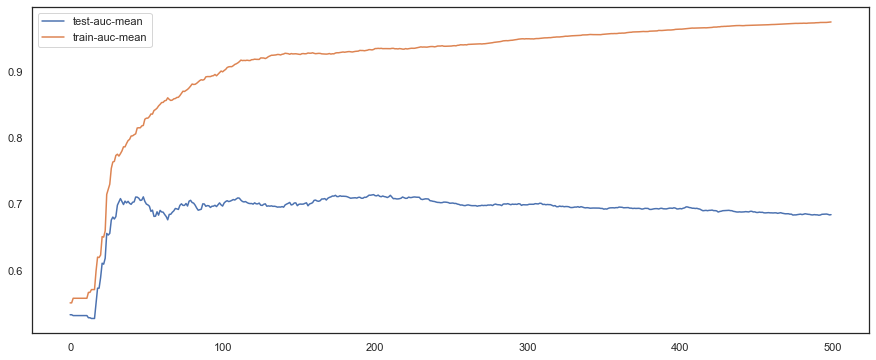

In [28]:
data_dmatrix = DMatrix(data=X,label=y)

param={
    'objective': 'binary:logistic',
    'learning_rate': 0.03,
    'gamma':0.0,
    'subsample':0.8,
    'colsample_bytree':0.0,
    'min_child_weight':3,
    'max_depth':6,
    'seed':1024,
    }


num_round=500
metric = 'auc'

print('running cross validation')

cv_results = cv(param, data_dmatrix, num_round, nfold=5,
       metrics={metric}, as_pandas=True, seed=0)

print(f"best test-auc-mean: {cv_results['test-auc-mean'].max()}")                
plot_history(cv_results, metric)


## XGBClassifier (Cross validation) + PCA

best test-auc-mean: 0.6182


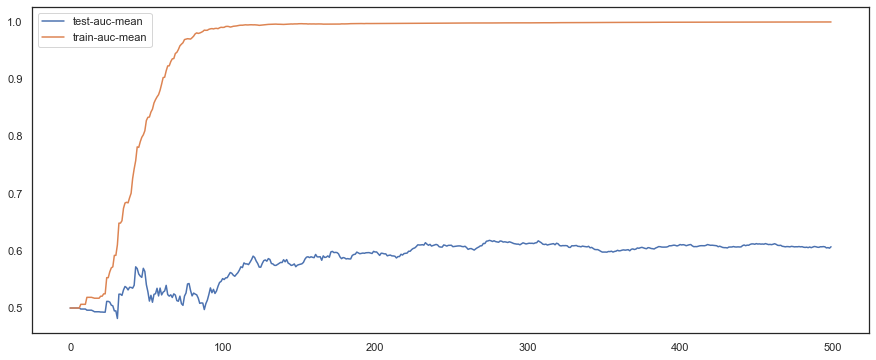

In [88]:

param={
    'objective': 'binary:logistic',
    'learning_rate': 0.03,
    'gamma':0.3,
    'subsample':0.8,
    'colsample_bytree':0.0,
    'min_child_weight':3,
    'max_depth':6,
    'seed':1024,
    }


num_round=500
metric = 'auc'

data_dmatrix = DMatrix(data=X_pca,label=y)
cv_results = cv(param, data_dmatrix, num_round, nfold=5,
       metrics={metric}, as_pandas=True, seed=0)

print(f"best test-auc-mean: {cv_results['test-auc-mean'].max():.4f}")                
plot_history(cv_results, metric)


### XGBClassifier 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

params={
    'n_estimators':500,
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':6,
    'seed':1024,
    }

clf = XGBClassifier(**params)
cv_results = clf.fit(X_train, y_train,
                     eval_set=[(X_train, y_train), (X_test, y_test)],
                     eval_metric='auc', early_stopping_rounds = 50,
                     verbose=True)


[0]	validation_0-auc:0.56209	validation_1-auc:0.54680
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.56209	validation_1-auc:0.54680
[2]	validation_0-auc:0.56209	validation_1-auc:0.54680
[3]	validation_0-auc:0.56209	validation_1-auc:0.54680
[4]	validation_0-auc:0.56182	validation_1-auc:0.54680
[5]	validation_0-auc:0.56182	validation_1-auc:0.54680
[6]	validation_0-auc:0.56182	validation_1-auc:0.54680
[7]	validation_0-auc:0.56211	validation_1-auc:0.54758
[8]	validation_0-auc:0.56211	validation_1-auc:0.54758
[9]	validation_0-auc:0.56211	validation_1-auc:0.54758
[10]	validation_0-auc:0.73356	validation_1-auc:0.68081
[11]	validation_0-auc:0.73356	validation_1-auc:0.68081
[12]	validation_0-auc:0.73356	validation_1-auc:0.68081
[13]	validation_0-auc:0.73356	validation_1-auc:0.68081
[14]	validation_0-auc:0.73348	validation_1-auc:0.68004
[15]	validation_0-auc:0.7334

[146]	validation_0-auc:0.92397	validation_1-auc:0.74269
Stopping. Best iteration:
[96]	validation_0-auc:0.88251	validation_1-auc:0.75451



## Полносвязная нейронная сеть - NN

In [14]:
# !pip install tensorflow

In [9]:
from sklearn.metrics import roc_curve, auc
from  keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
X.shape

def plot_history(hist):
    plt.plot(hist.history['auc'], label='train')
    plt.plot(hist.history['val_auc'], label='test')
    plt.title('Model auc')
    plt.xlabel('Epoch number')
    plt.ylabel('auc')
    plt.legend(loc='lower right')
    plt.show()


In [10]:
for n in [4,8,16,32,64]:
    print(f'==== newrons in first layer: {n} ====')
    for drop in [0,.1,.2,.3,.4,.5]:
        model = Sequential()
        model.add(Dense(n, activation='relu', input_shape=(46,)))
        model.add(Dropout(drop))
        model.add(Dense(n*2, activation='relu'))
        model.add(Dropout(drop))
        model.add(Dense(n, activation='relu'))
        model.add(Dropout(drop))
        model.add(Dense(5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

        history = model_train = model.fit(X, y, epochs=200, batch_size=50, verbose=0, validation_split=0.2)
        print(f"Dropout={drop} => maximum auc={max(history.history['val_auc']):.3f}")
#     plot_history(history)

==== newrons in first layer: 4 ====
Dropout=0 => maximum auc=0.608
Dropout=0.1 => maximum auc=0.549
Dropout=0.2 => maximum auc=0.611
Dropout=0.3 => maximum auc=0.655
Dropout=0.4 => maximum auc=0.599
Dropout=0.5 => maximum auc=0.611
==== newrons in first layer: 8 ====
Dropout=0 => maximum auc=0.571
Dropout=0.1 => maximum auc=0.602
Dropout=0.2 => maximum auc=0.695
Dropout=0.3 => maximum auc=0.602
Dropout=0.4 => maximum auc=0.596
Dropout=0.5 => maximum auc=0.576
==== newrons in first layer: 16 ====
Dropout=0 => maximum auc=0.758
Dropout=0.1 => maximum auc=0.675
Dropout=0.2 => maximum auc=0.612
Dropout=0.3 => maximum auc=0.621
Dropout=0.4 => maximum auc=0.694
Dropout=0.5 => maximum auc=0.589
==== newrons in first layer: 32 ====
Dropout=0 => maximum auc=0.577
Dropout=0.1 => maximum auc=0.691
Dropout=0.2 => maximum auc=0.590
Dropout=0.3 => maximum auc=0.604
Dropout=0.4 => maximum auc=0.619
Dropout=0.5 => maximum auc=0.600
==== newrons in first layer: 64 ====
Dropout=0 => maximum auc=0.620
Dr

## Newral Network  k-Fold Cross Validation

In [92]:
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
n=16
drop = 0.0
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(n, activation='relu', input_shape=(46,)))
    model.add(Dropout(drop))
    model.add(Dense(n*2, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(n, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc')])
    # Fit the model
    model.fit(X.iloc[train,:], y.iloc[train], epochs=200, batch_size=50, verbose=0)
    # evaluate the model
    scores = model.evaluate(X.iloc[test,:], y.iloc[test], verbose=0)
    print(f"{model.metrics_names[1]}: {scores[1]:.3f}")
    cvscores.append(scores[1])
print(f"{numpy.mean(cvscores):.3f} (+/- {numpy.std(cvscores):.3f})")

auc: 0.557
auc: 0.584
auc: 0.611
auc: 0.518
auc: 0.586
0.571 (+/- 0.032)
